# Actor Critic

## Actor Critic Methods

Actor-Critic methods are [temporal difference (TD) learning](https://en.wikipedia.org/wiki/Temporal_difference_learning) methods that represent the policy function independent of the value function.

A policy function (or policy) returns a probability distribution over actions that the agent can take based on the given state.
A value function determines the expected return for an agent starting at a given state and acting according to a particular policy forever after.

In the Actor-Critic method, the policy is referred to as the *actor* that proposes a set of possible actions given a state, and the estimated value function is referred to as the *critic*, which evaluates actions taken by the *actor* based on the given policy.

In this tutorial, both the *Actor* and *Critic* will be represented using one neural network with two outputs.




### 3. The Actor-Critic loss

Since you're using a hybrid Actor-Critic model, the chosen loss function is a combination of Actor and Critic losses for training, as shown below:

$$L = L_{actor} + L_{critic}$$

#### The Actor loss

The Actor loss is based on [policy gradients with the Critic as a state dependent baseline](https://www.youtube.com/watch?v=EKqxumCuAAY&t=62m23s) and computed with single-sample (per-episode) estimates.

$$L_{actor} = -\sum^{T}_{t=1} \log\pi_{\theta}(a_{t} | s_{t})[G(s_{t}, a_{t})  - V^{\pi}_{\theta}(s_{t})]$$

where:
- $T$: the number of timesteps per episode, which can vary per episode
- $s_{t}$: the state at timestep $t$
- $a_{t}$: chosen action at timestep $t$ given state $s$
- $\pi_{\theta}$: is the policy (Actor) parameterized by $\theta$
- $V^{\pi}_{\theta}$: is the value function (Critic) also parameterized by $\theta$
- $G = G_{t}$: the expected return for a given state, action pair at timestep $t$

A negative term is added to the sum since the idea is to maximize the probabilities of actions yielding higher rewards by minimizing the combined loss.

<br>

##### The Advantage

The $G - V$ term in our $L_{actor}$ formulation is called the [Advantage](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#advantage-functions), which indicates how much better an action is given a particular state over a random action selected according to the policy $\pi$ for that state.

While it's possible to exclude a baseline, this may result in high variance during training. And the nice thing about choosing the critic $V$ as a baseline is that it trained to be as close as possible to $G$, leading to a lower variance.

In addition, without the Critic, the algorithm would try to increase probabilities for actions taken on a particular state based on expected return, which may not make much of a difference if the relative probabilities between actions remain the same.

For instance, suppose that two actions for a given state would yield the same expected return. Without the Critic, the algorithm would try to raise the probability of these actions based on the objective $J$. With the Critic, it may turn out that there's no Advantage ($G - V = 0$), and thus no benefit gained in increasing the actions' probabilities and the algorithm would set the gradients to zero.

Due to the usage of this advantage function, this algorithm is also **Advantage Actor Critic (A2C)**.
<br>

#### The Critic loss

Training $V$ to be as close possible to $G$ can be set up as a regression problem with the following loss function:

$$L_{critic} = L_{\delta}(G, V^{\pi}_{\theta})$$

where $L_{\delta}$ is the [Huber loss](https://en.wikipedia.org/wiki/Huber_loss), which is less sensitive to outliers in data than squared-error loss.


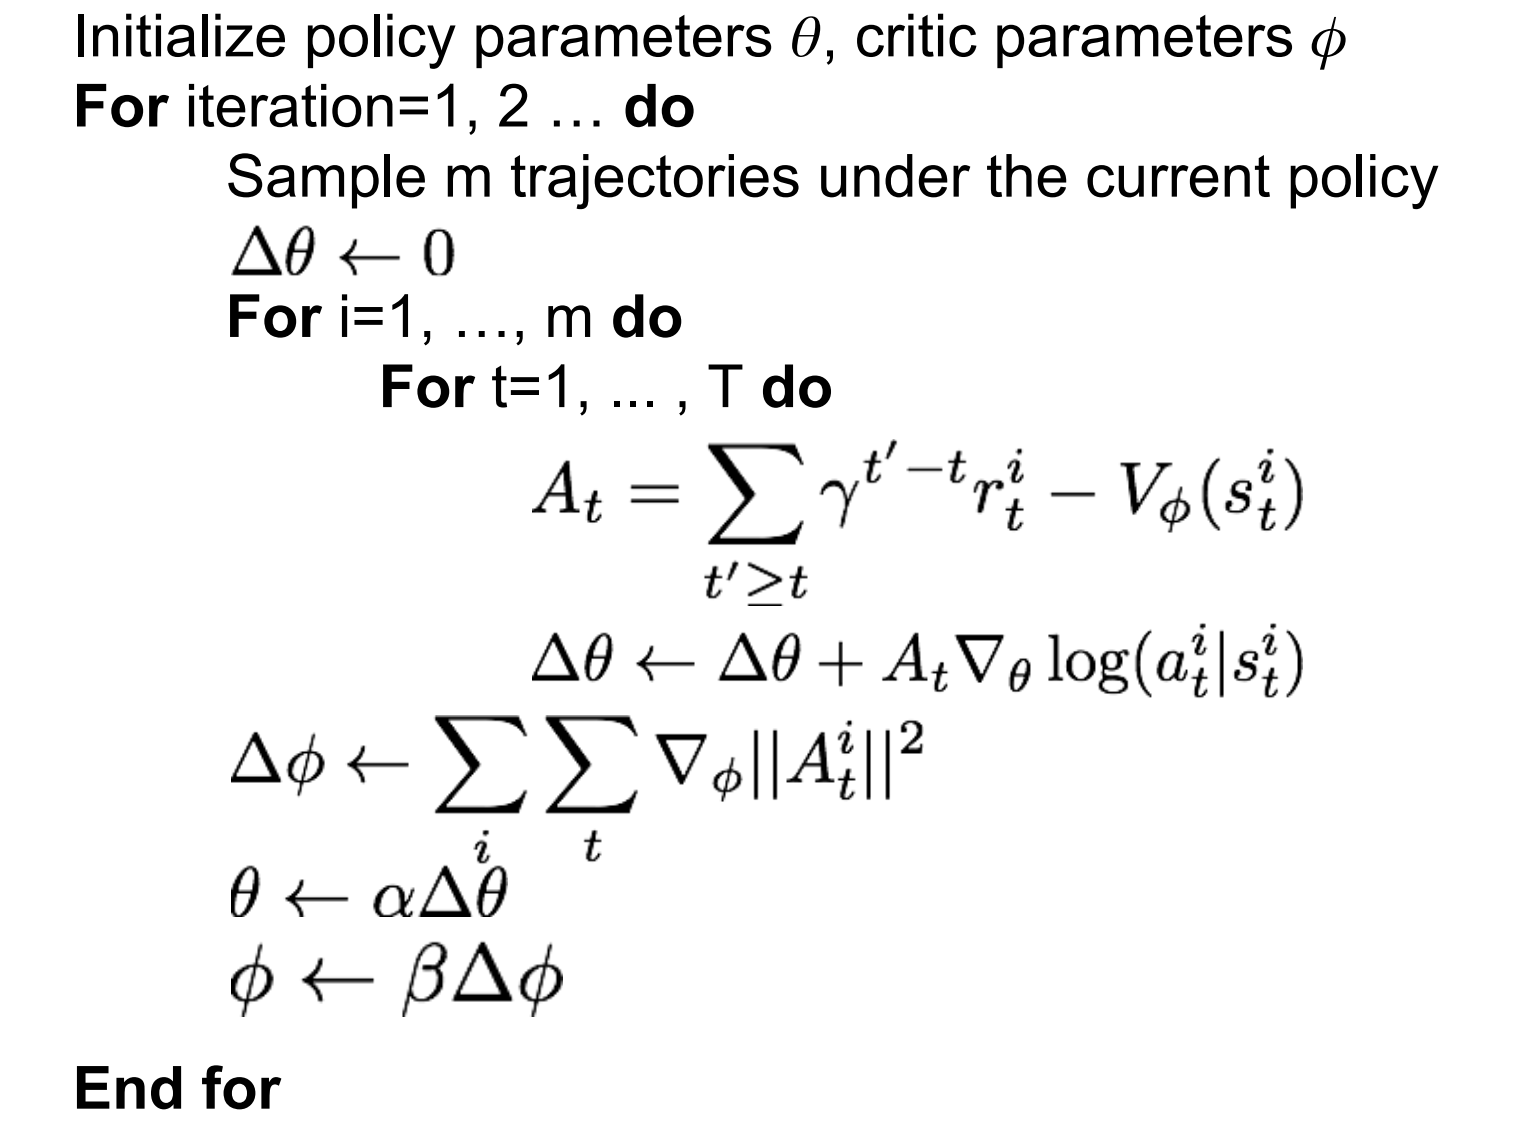

In [1]:
!pip install -q swig
!pip install -q gym[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 47.3 MB/s eta 0:00:00


In [2]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import deque, namedtuple

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Categorical

In [11]:
from torch.distributions import Normal

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:

env = gym.make('MountainCarContinuous-v0')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


### Actor Critic Network

In [192]:
class Actor_net(nn.Module):
  def __init__(self,n_observations, n_actions):
    super(Actor_net, self).__init__()
    self.aff1 = nn.Linear(n_observations, 40)
    nn.init.xavier_uniform(self.aff1.weight)
    self.df1 = nn.Dropout(0.5)
    self.aff2 = nn.Linear(40,40)
    nn.init.xavier_uniform(self.aff2.weight)
    self.df2 = nn.Dropout(0.5)
    self.mu = nn.Linear(40,n_actions)
    nn.init.xavier_uniform(self.mu.weight)
    self.log_std = nn.Linear(40,n_actions)
    nn.init.xavier_uniform(self.log_std.weight)

  def forward(self,x):
    x = F.leaky_relu(self.df1(self.aff1(x)))
    x = F.leaky_relu(self.df2(self.aff2(x)))
    return self.mu(x),self.log_std(x)

  def act(self, state):
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)

    mu, logstd = self.forward(state)

    sigma = torch.exp(logstd)+1e-10
    m = Normal(mu,sigma)
    action = m.sample()

    return action.item(), m.log_prob(action)

In [193]:
class Critic_net(nn.Module):
  def __init__(self,n_observations, n_actions):
    super(Critic_net, self).__init__()
    self.aff1 = nn.Linear(n_observations, 400)
    nn.init.xavier_uniform(self.aff1.weight)
    self.df1 = nn.Dropout(0.5)
    self.aff2 = nn.Linear(400,400)
    nn.init.xavier_uniform(self.aff2.weight)
    self.df2 = nn.Dropout(0.5)
    self.out = nn.Linear(400,n_actions)

  def forward(self,x):
    x = F.leaky_relu(self.df1(self.aff1(x)))
    x = F.leaky_relu(self.df2(self.aff2(x)))
    return self.out(x)

  def act(self,state):
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)
    a = self.forward(state)
    return a.squeeze(0)

In [194]:
class ActorCritic(nn.Module):
    """
    implements both actor and critic in one model
    """
    def __init__(self, n_observations, n_actions):
        super(ActorCritic, self).__init__()
        self.affine1 = nn.Linear(n_observations, 128)
        nn.init.xavier_uniform(self.affine1.weight)
        self.affine2 = nn.Linear(128,256)
        nn.init.xavier_uniform(self.affine2.weight)
        self.affine3 = nn.Linear(256,64)
        nn.init.xavier_uniform(self.affine3.weight)
    
        self.action_head = nn.Linear(64, n_actions)
        nn.init.xavier_uniform(self.action_head.weight)
        self.value_head = nn.Linear(64, 1)
        nn.init.xavier_uniform(self.value_head.weight)
        self.logvar = nn.Parameter(torch.zeros(n_actions),requires_grad=True)


    def forward(self, x):
        """
        forward of both actor and critic
        """
        x = F.leaky_relu(self.affine1(x))
        x = F.leaky_relu(self.affine2(x))
        x = F.leaky_relu(self.affine3(x))
        mu = self.action_head(x)
        state_values = self.value_head(x)
        return mu,state_values

    def act(self, state,explore):
        so = state
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        mu, state_value = self.forward(state)
        sigma = torch.exp(self.logvar)+1e-10
        m = Normal(mu,sigma)
        action = m.sample()


        return action.item(), m.log_prob(action), state_value.squeeze(0)

### Hyperparameters

In [195]:

total_episodes = 1000     
max_steps = 500             
learning_rate = 1e-2   
actor_lr = 2e-5
critic_lr = 1e-3
gamma = 0.99              

### Training

In [196]:
print('observation space:', env.observation_space)
print('action space:', env.action_space)

state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]
print('state size:', state_size)
print('action size:', action_size)

observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
action space: Box(-1.0, 1.0, (1,), float32)
state size: 2
action size: 1


In [197]:
# Intialize policy network
# actor_critic = ActorCritic(state_size, action_size).to(device)
actor = Actor_net(state_size,action_size).to(device)
critic = Critic_net(state_size,action_size).to(device)
# set up the optimizer
optim_actor = optim.Adam(actor.parameters(), lr=actor_lr)
optim_critic = optim.Adam(critic.parameters(), lr=critic_lr)

<ipython-input-192-61a97f1f3bbf>:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.aff1.weight)
<ipython-input-192-61a97f1f3bbf>:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.aff2.weight)
<ipython-input-192-61a97f1f3bbf>:11: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.mu.weight)
<ipython-input-192-61a97f1f3bbf>:13: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.log_std.weight)


In [198]:
scores = []
for episode in range(1, total_episodes+1):
  saved_log_probs = []
  rewards = []
  saved_buffer = {'log_prob':[], 'value':[]}
  state = env.reset()
  done = False
  while (not done):
    action, log_prob = actor.act(state)
    value = critic.act(state)
    state, reward, done, _ = env.step([action])
    if reward >0:
      reward = 100_000
    rewards.append(reward)
    saved_buffer["log_prob"].append(log_prob)
    saved_buffer["value"].append(value)
    if done:
        break

  scores.append(sum(rewards))
  returns = deque(maxlen=max_steps)
  n_steps = len(rewards)

  for t in range(n_steps)[::-1]:
    disc_return_t = (returns[0] if len(returns)>0 else 0)
    returns.appendleft( gamma*disc_return_t + rewards[t]   )
  eps = np.finfo(np.float32).eps.item()
  returns = torch.tensor(returns)
  returns = (returns - returns.mean()) / (returns.std() + eps)

  policy_losses = [] 
  value_losses = [] 

  for log_prob, value, R in zip(saved_buffer["log_prob"], saved_buffer["value"], returns):
    advantage = R - value.item()

    policy_losses.append(-log_prob * advantage)
    value_losses.append(F.smooth_l1_loss(value, torch.tensor([R], device=device)))

  loss_p = torch.stack(policy_losses).sum()
  loss_v = torch.stack(value_losses).sum()

  optim_actor.zero_grad()
  loss_p.backward()
  optim_actor.step()

  optim_critic.zero_grad()
  loss_v.backward()
  optim_critic.step()


  print(f"Episode {episode}: Reward = {scores[-1]}")


Episode 1: Reward = -233.7750779435328
Episode 2: Reward = -195.72954359666153
Episode 3: Reward = -241.16610007488333
Episode 4: Reward = -260.5344453128071
Episode 5: Reward = -224.94549516044728
Episode 6: Reward = -247.2501000700001
Episode 7: Reward = -205.61140507519826
Episode 8: Reward = -245.06263171570887
Episode 9: Reward = -225.83094975336468
Episode 10: Reward = 99778.28578103005
Episode 11: Reward = -221.01569599049196
Episode 12: Reward = -194.02394918043726
Episode 13: Reward = -213.95781885477828
Episode 14: Reward = -233.52278157158275
Episode 15: Reward = -239.2264443802127
Episode 16: Reward = -198.351051993895
Episode 17: Reward = -243.48343624503053
Episode 18: Reward = 99794.3160320881
Episode 19: Reward = -211.99464551742727
Episode 20: Reward = -232.61737860111927
Episode 21: Reward = -295.550367954018
Episode 22: Reward = -225.47675219821582
Episode 23: Reward = -275.5857568388719
Episode 24: Reward = 99817.21688750558
Episode 25: Reward = 99873.55909973901
Ep

Text(0, 0.5, 'Reward')

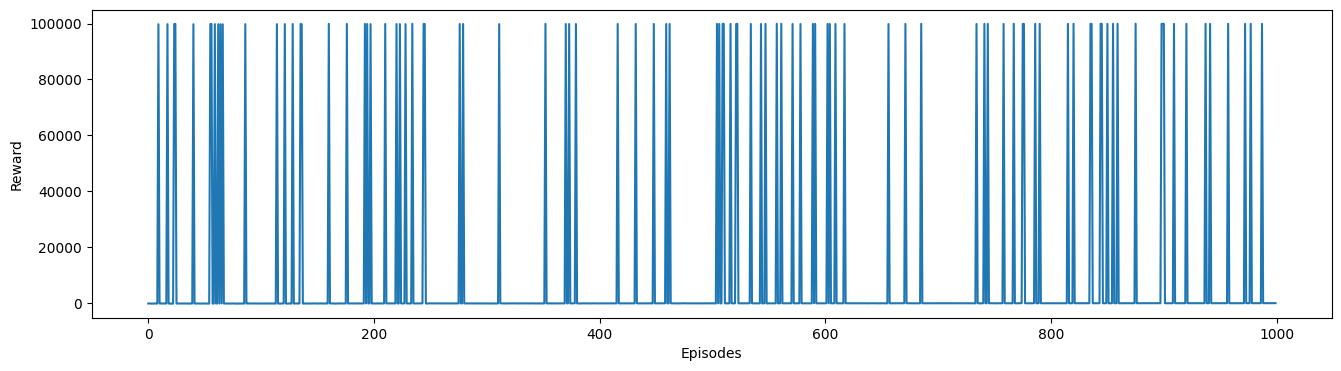

In [200]:

plt.figure(figsize=(16,4))
plt.plot(scores)
plt.xlabel("Episodes")
plt.ylabel("Reward")

### Visualization

In [201]:
# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
import base64, io, os

os.environ['SDL_VIDEODRIVER']='dummy'

In [208]:
os.makedirs("video", exist_ok=True)

def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(env_name):
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    state = env.reset()
    done = False
    score = 0
    for t in range(max_steps):
        vid.capture_frame()
        action,_ = actor.act(state)
        next_state, reward, done, info = env.step([action])
        state = next_state
        score = reward
        if done:
            break
    print(score)
    vid.close()
    env.close()

In [209]:
show_video_of_model('MountainCarContinuous-v0')

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment MountainCarContinuous-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initializati

-0.48508554796013076


In [210]:
show_video('MountainCarContinuous-v0')